# Определение возраста покупателей

## Исследовательский анализ данных

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import tensorflow as tf
from tensorflow.keras.datasets import fashion_mnist
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications.resnet import ResNet50
from tensorflow.keras.layers import Conv2D, Flatten, Dense, AvgPool2D, AveragePooling2D, GlobalAveragePooling2D
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam

In [2]:
labels = pd.read_csv('/datasets/faces/labels.csv')

In [3]:
labels.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7591 entries, 0 to 7590
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   file_name  7591 non-null   object
 1   real_age   7591 non-null   int64 
dtypes: int64(1), object(1)
memory usage: 118.7+ KB


In [4]:
labels.sample(10)

,file_name,real_age
6206,006209.jpg,24
2978,002978.jpg,16
7447,007469.jpg,18
7113,007128.jpg,7
4977,004977.jpg,37
331,000331.jpg,15
1997,001997.jpg,30
4340,004340.jpg,50
4182,004182.jpg,17
7364,007386.jpg,50


In [5]:
labels.describe()

,real_age
count,7591.000000
mean,31.201159
std,17.145060
min,1.000000
25%,20.000000
50%,29.000000
75%,41.000000
max,100.000000


In [6]:
train_datagen = ImageDataGenerator(rescale=1./255)

In [7]:
%%time
train_gen_flow = train_datagen.flow_from_dataframe(
        dataframe=labels,
        directory='/datasets/faces/final_files/',
        x_col='file_name',
        y_col='real_age',
        class_mode='raw',
        shuffle=True,
        target_size=(224, 224),
        subset='training',
        batch_size=32,
        seed=12345)

Found 7591 validated image filenames.
CPU times: user 667 ms, sys: 354 ms, total: 1.02 s
Wall time: 1min 24s


In [8]:
features, target = next(train_gen_flow)

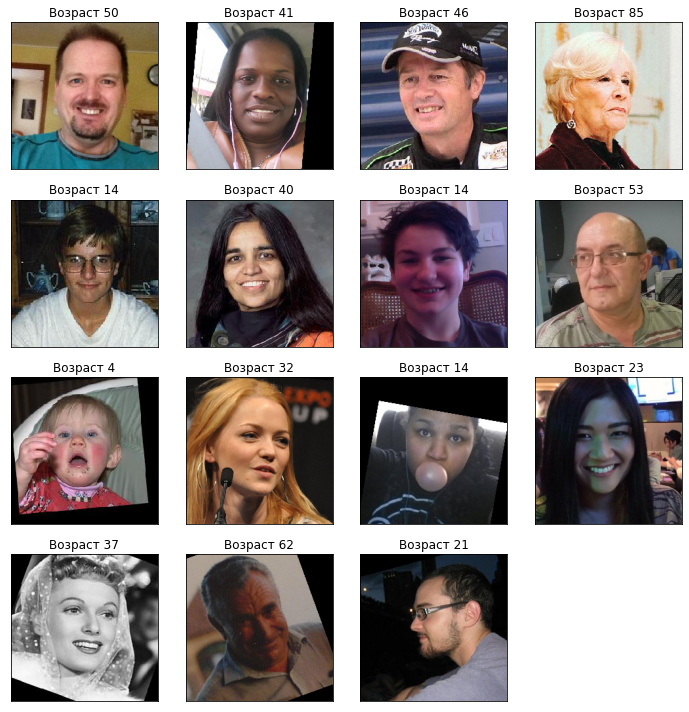

In [9]:
fig = plt.figure(figsize=(10,10))
for i in range(15):
    fig.add_subplot(4, 4, i+1)
    plt.imshow(features[i])
    plt.title(f'Возраст {target[i]}')
    plt.xticks([])
    plt.yticks([])
    plt.tight_layout()

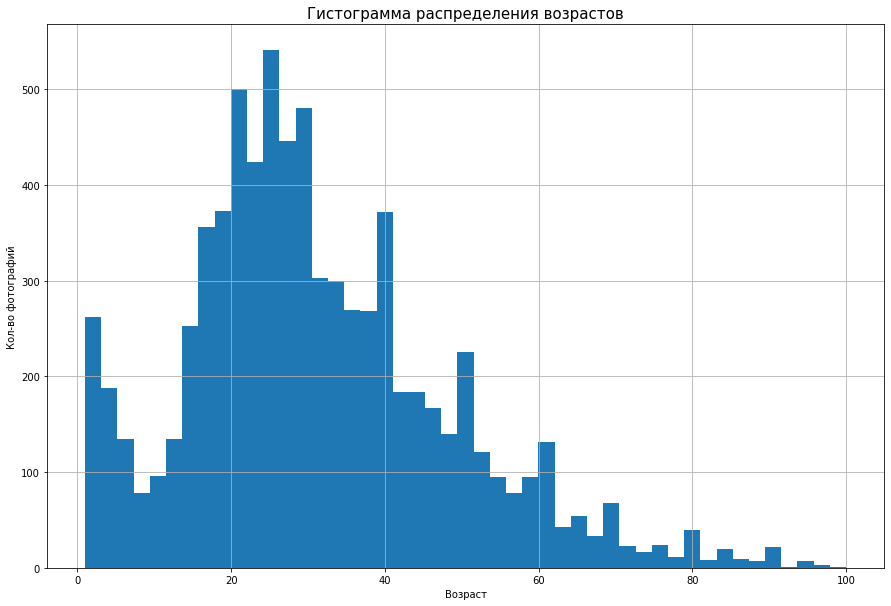

In [10]:
labels.hist(bins='auto', figsize=(15,10))
plt.ylabel('Кол-во фотографий')
plt.xlabel('Возраст')
plt.title('Гистограмма распределения возрастов', size=15);

Вывод:

* всего 7591 записей.
* некоторые картинки перевернуты, на некоторых не полное отображение лица, встречаются черно-белые и цветные фотографии, у некоторых людей часть лица чем-нибудь закрыта (жевачка, очки, микрофон, наушники);
* больше всего людей в возрасте от 18 до 40 лет.

## Обучение модели

  
```python 
from tensorflow.keras.applications.resnet import ResNet50
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, Flatten
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
import numpy as np
import pandas as pd


def load_train(path):

    df = pd.read_csv('/datasets/faces/labels.csv')

    train_datagen = ImageDataGenerator(
        rescale=1. / 255,
        validation_split=0.2)

    train_gen_flow = train_datagen.flow_from_dataframe(
        dataframe=df,
        directory='/datasets/faces/final_files/',
        x_col='file_name',
        y_col='real_age',
        target_size=(224, 224),
        batch_size=32,
        class_mode='raw',
        subset='training',
        seed=12345)

    return train_gen_flow

def load_test(path):

    df = pd.read_csv('/datasets/faces/labels.csv')

    valid_datagen = ImageDataGenerator(
        rescale=1. / 255, 
        validation_split=0.2)

    validation_gen_flow = valid_datagen.flow_from_dataframe(
        dataframe=df,
        directory='/datasets/faces/final_files/',
        x_col='file_name',
        y_col='real_age',
        target_size=(224, 224),
        batch_size=32,
        class_mode='raw',
        subset='validation',
        seed=12345)

    return validation_gen_flow


def create_model(input_shape):
    backbone = ResNet50(input_shape=input_shape,
                        weights='imagenet',
                        include_top=False)
    model = Sequential()
    model.add(backbone)
    model.add(GlobalAveragePooling2D())
    model.add(Dense(1, activation='linear'))

    optimizer = Adam(lr=0.0001)
    
    model.compile(optimizer=optimizer, loss='mse', metrics=['mae'])

    return model


def train_model(model, train_data, test_data, epochs=5, steps_per_epoch=None, validation_steps=None):
    model.fit(train_data,
                validation_data=test_data,
                steps_per_epoch=steps_per_epoch,
                epochs=epochs,
                validation_steps=validation_steps,
                verbose=2)

    return model
```

Found 6073 validated image filenames.
Found 1518 validated image filenames.

Train for 190 steps, validate for 48 steps \
Epoch 1/5 \
190/190 - 47s - loss: 242.7579 - mae: 11.0927 - val_loss: 651.0009 - val_mae: 20.4313 \
Epoch 2/5 \
190/190 - 39s - loss: 62.1568 - mae: 5.9665 - val_loss: 812.5513 - val_mae: 23.4660 \
Epoch 3/5 \
190/190 - 38s - loss: 31.0072 - mae: 4.3222 - val_loss: 397.7245 - val_mae: 14.7935 \
Epoch 4/5 \
190/190 - 38s - loss: 20.7044 - mae: 3.5121 - val_loss: 112.9650 - val_mae: 7.9618 \
Epoch 5/5 \
190/190 - 38s - loss: 15.7229 - mae: 3.0713 - val_loss: 99.3169 - val_mae: 7.9167 \

48/48 - 8s - loss: 99.3169 - mae: 7.9167 \
Test MAE: 7.9167

## Анализ обученной модели

Лучшая метрика MAE, после 5 эпох, на тренировочной выборке 3.07, на валидационной 7.91